In [153]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
import tensorflow.keras as keras

plt.style.use("seaborn")

%matplotlib inline

In [77]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [78]:
dataframe.iloc[:,-1].value_counts()

1.0    2919
0.0    2079
Name: 140, dtype: int64

In [79]:
data = raw_data[:,0:-1]
labels =raw_data[:,-1]

In [80]:
data.shape, labels.shape

((4998, 140), (4998,))

In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [82]:
X_train.shape, X_test.shape

((3998, 140), (1000, 140))

In [84]:
mmScaler = MinMaxScaler()
mmScaler.fit(X_train)
X_train_scaled = mmScaler.transform(X_train)
X_test_scaled = mmScaler.transform(X_test)

X_train_scaled = tf.cast(X_train_scaled, tf.float32)
X_test_scaled = tf.cast(X_test_scaled, tf.float32)

In [85]:
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

In [86]:
normal_X_train = X_train_scaled[y_train]
normal_X_test = X_test_scaled[y_test]

abnormal_X_train = X_train_scaled[~y_train]
abnormal_X_test = X_test_scaled[~y_test]

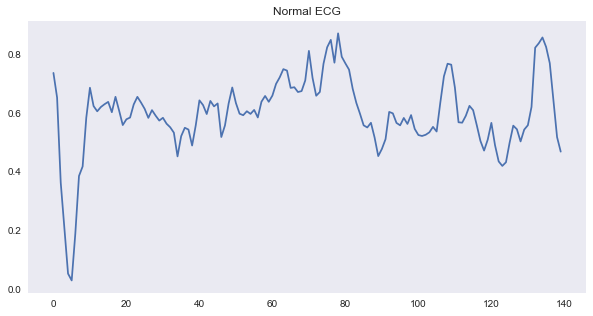

In [87]:
plt.figure(figsize=(10, 5))
plt.plot(normal_X_train[0])
plt.title("Normal ECG")
plt.grid()
plt.show()

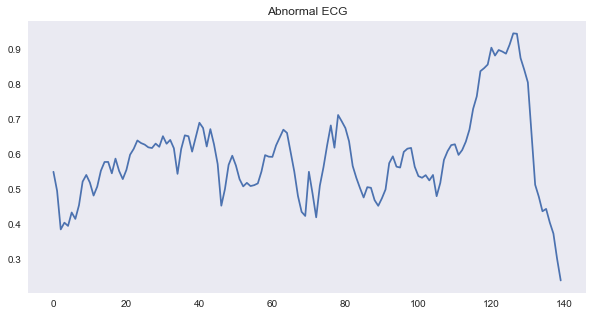

In [88]:
plt.figure(figsize=(10,5))
plt.plot(abnormal_X_train[0])
plt.title("Abnormal ECG")
plt.grid()
plt.show()

In [89]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector,self).__init__()
        self.encoder = keras.Sequential([
            keras.layers.Dense(32,activation='relu'),
            keras.layers.Dense(16,activation='relu'),
            keras.layers.Dense(8,activation='relu'),
        ])
        self.decoder = keras.Sequential([
            keras.layers.Dense(16,activation='relu'),
            keras.layers.Dense(32,activation='relu'),
            keras.layers.Dense(140,activation='sigmoid'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [90]:
autoencoder  = AnomalyDetector()
autoencoder.compile(loss='mae',optimizer='adam')

In [91]:
model = autoencoder.fit(normal_X_train,normal_X_train, epochs=20,batch_size=512, validation_data=(X_test_scaled,X_test_scaled),shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 31ms/step - loss: 0.1302 - val_loss: 0.1366
Epoch 2/20
5/5 [==============================] - 0s 8ms/step - loss: 0.1276 - val_loss: 0.1329
Epoch 3/20
5/5 [==============================] - 0s 7ms/step - loss: 0.1229 - val_loss: 0.1267
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.1162 - val_loss: 0.1187
Epoch 5/20
5/5 [==============================] - 0s 12ms/step - loss: 0.1080 - val_loss: 0.1100
Epoch 6/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0982 - val_loss: 0.1017
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0877 - val_loss: 0.0950
Epoch 8/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0779 - val_loss: 0.0895
Epoch 9/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0692 - val_loss: 0.0850
Epoch 10/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0619 - val_loss: 0.0825
Epoch 11/20
5/5 [=================

In [92]:
training_loss = model.history['loss']
validation_loss = model.history['val_loss']

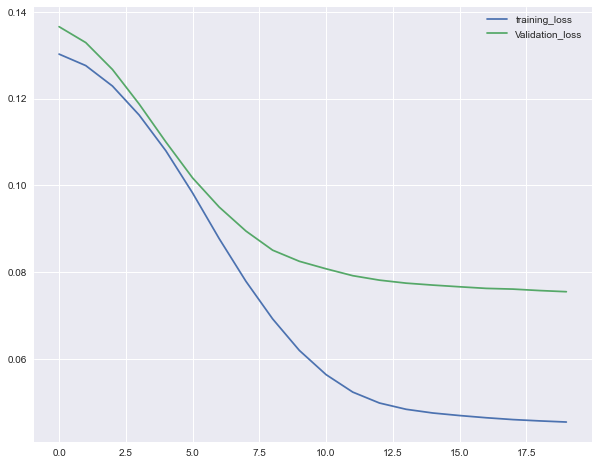

In [95]:
plt.figure(figsize=(10,8))
plt.plot(training_loss, label="training_loss")
plt.plot(validation_loss, label="Validation_loss")
plt.legend()

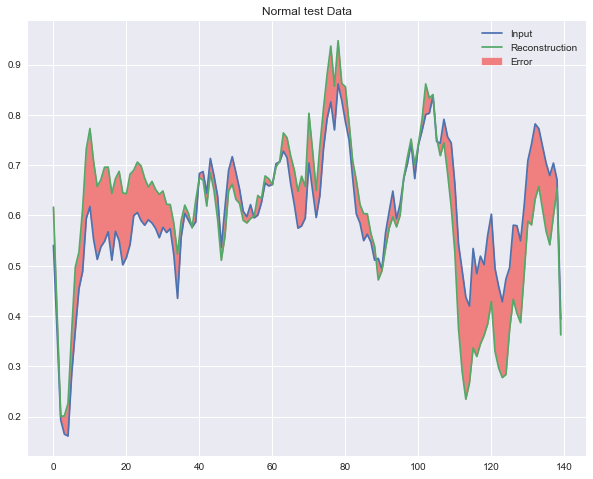

In [136]:
predicted_data = autoencoder.predict(tf.reshape(normal_X_test[0], [1,140]))
plt.figure(figsize=(10,8))
plt.plot(predicted_data[0])
plt.plot(normal_X_test[0])
plt.fill_between(np.arange(140),predicted_data[0], normal_X_test[0], color='lightcoral')
plt.title("Normal test Data")
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

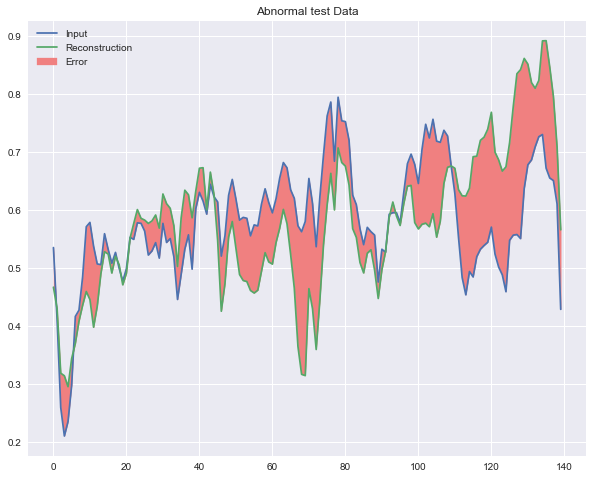

In [138]:
predicted_data = autoencoder.predict(tf.reshape(abnormal_X_test[0], [1,140]))
plt.figure(figsize=(10,8))
plt.plot(predicted_data[0])
plt.plot(abnormal_X_test[0])
plt.fill_between(np.arange(140),predicted_data[0], abnormal_X_test[0], color='lightcoral')
plt.title("Abnormal test Data")
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

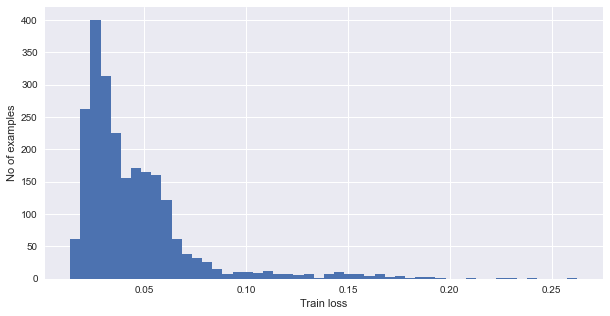

In [151]:
reconstructed_data = autoencoder.predict(normal_X_train)
training_error = tf.keras.losses.mae(reconstructed_data,normal_X_train)

plt.figure(figsize=(10,5))
plt.hist(training_error[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

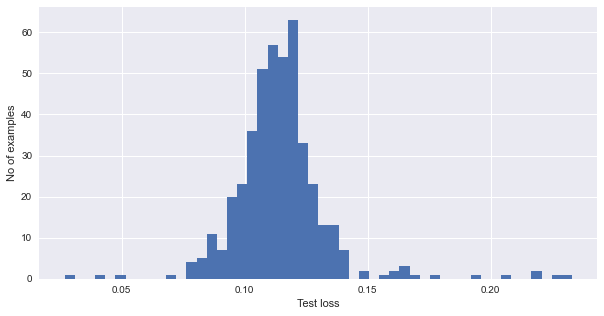

In [150]:
reconstructed_data = autoencoder.predict(abnormal_X_test)
test_error = tf.keras.losses.mae(reconstructed_data, abnormal_X_test)

plt.figure(figsize=(10,5))
plt.hist(test_error[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [154]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [161]:
threshold = np.mean(training_error) + np.std(training_error)
print(f"Thrshold : {threshold}")
preds = predict(autoencoder, X_test_scaled, threshold)
print_stats(preds, y_test)

Thrshold : 0.07469221204519272
Accuracy = 0.946
Precision = 0.9922178988326849
Recall = 0.9107142857142857
